#Customer Churn Prediction Analysis

##Introduction

Goal: Predict customer churn for a telecom company using machine learning.


#Data Preprocessing and preparation

##Loading the necessary libraries

In [34]:
#import the necessary libraries
import pandas as pd
import os
import os
import kagglehub
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [2]:
#To make the code reproducible
np.random.seed(42)

###Loading the Dataset

In [3]:
# Download latest version
path = kagglehub.dataset_download("alfathterry/telco-customer-churn-11-1-3")

print("Path to dataset files:", path)
print(os.listdir(path))
#Load the data into a pandas dataframe
csv_file = os.path.join(path, "telco.csv")
df = pd.read_csv(csv_file)

100%|██████████| 513k/513k [00:00<00:00, 88.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/alfathterry/telco-customer-churn-11-1-3/versions/1
['telco.csv']


This is the IBM Watson Telco Customer Churn Dataset.his dataset contains information about telecom customers, including:

In [4]:
# Group columns by type
demographics = ['Customer ID', 'Gender', 'Age', 'Under 30', 'Senior Citizen',
                   'Married', 'Dependents', 'Number of Dependents', 'Country',
                   'State', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Population']
account_info = ['Quarter', 'Referred a Friend', 'Number of Referrals',
                   'Tenure in Months', 'Offer', 'Contract', 'Paperless Billing',
                   'Payment Method']
services = ['Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type',
               'Online Security', 'Online Backup', 'Device Protection Plan',
               'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
               'Streaming Music', 'Unlimited Data']
billing = ['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
              'Monthly Charge', 'Total Charges', 'Total Refunds',
              'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']
satisfaction = ['Satisfaction Score']

churn_related = ['Customer Status', 'Churn Label', 'Churn Score', 'CLTV',
                    'Churn Category', 'Churn Reason']


In [5]:
#Display the first few rows of the dataset
print(df.head())
# Check dataset information
df.info()
# Summary statistics
print(df.describe())

  Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ  Female   80       No            Yes     Yes        Yes   

   Number of Dependents        Country       State  ...  \
0                     0  United States  California  ...   
1                     1  United States  California  ...   
2                     3  United States  California  ...   
3                     1  United States  California  ...   
4                     1  United States  California  ...   

  Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                       20                         0.00          59.65   
1                        0                       390.80   

###Handle Missing values

In [6]:
# Count missing values per column
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Offer             3877
Internet Type     1526
Churn Category    5174
Churn Reason      5174
dtype: int64


In [8]:
# Handling missing values in 'Churn Category' and 'Churn Reason'
# Filling with 'No Churn' makes sense as these columns only apply to churned customers
df["Churn Category"].fillna("No Churn", inplace=True)
df["Churn Reason"].fillna("No Churn Reason", inplace=True)

# For 'Internet Type' and 'Offer', using mode imputation as these are categorical
# and the most frequent value is a reasonable default
df["Internet Type"].fillna(df["Internet Type"].mode()[0], inplace=True)
df["Offer"].fillna(df["Internet Type"].mode()[0], inplace=True)

###Dropping duplicates

In [9]:
# Drop duplicates
df.drop_duplicates(inplace=True)

###Performing Feature Engineering

In [10]:
#Feature engineering-Binning Tenure
df['Tenure Group'] = pd.cut(df['Tenure in Months'], bins=[0, 12, 36, 60, np.inf], labels=['New', '1-3 Years', '3-5 Years', '5+ Years'])
df.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason,Tenure Group
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data,New
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer,New
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer,1-3 Years
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services,1-3 Years
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges,3-5 Years


###Dropping uneccessary columns

In [11]:
# Drop unwanted columns
cols_to_drop = ["Customer ID", "Zip Code", "City", "State", "Country", "Latitude", "Longitude", "Population", "Churn Label", "Total Revenue"]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

###Encoding Categorical variables

In [12]:
# Encoding Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
label_enc_cols = ['Contract', 'Tenure Group', 'Payment Method']  # Ordinal Categories
one_hot_cols = list(set(categorical_cols) - set(label_enc_cols))
# Label Encoding
le = LabelEncoder()
for col in label_enc_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)
print(df.head())

   Age  Number of Dependents  Number of Referrals  Tenure in Months  \
0   78                     0                    0                 1   
1   74                     1                    1                 8   
2   71                     3                    0                18   
3   78                     1                    1                25   
4   80                     1                    1                37   

   Avg Monthly Long Distance Charges  Avg Monthly GB Download  Contract  \
0                               0.00                        8         0   
1                              48.85                       17         0   
2                              11.33                       52         0   
3                              19.76                       12         0   
4                               6.33                       14         0   

   Payment Method  Monthly Charge  Total Charges  ...  \
0               0           39.65          39.65  ...   
1       

###Defining the Target Variable

In [13]:
# Define target variable
if 'Customer Status_Joined' in df.columns and 'Customer Status_Stayed' in df.columns:
    df['Churn'] = (~df[['Customer Status_Joined', 'Customer Status_Stayed']].any(axis=1)).astype(int)
    df.drop(columns=['Customer Status_Joined', 'Customer Status_Stayed'], inplace=True)
elif 'Churn Label' in df.columns:
    df['Churn'] = df['Churn Label'].apply(lambda x: 1 if x == 'Churned' else 0)
    df.drop(columns=['Churn Label'], inplace=True)
else:
    raise ValueError("Churn labels not found!")

###Feature Selection

In [14]:
# Separate features and target (before any scaling)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Temporary scaling just for feature selection
temp_scaler = MinMaxScaler()
X_temp = pd.DataFrame(temp_scaler.fit_transform(X), columns=X.columns)

# Select top 15 features using mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_new = selector.fit_transform(X_temp, y)
selected_features = X.columns[selector.get_support()]

print("Selected Features:")
print(selected_features)

# 2. Prepare final features with proper scaling
# Create copy with only selected features
X_final = df[selected_features].copy()  # Note the .copy() here

# Identify numerical columns
num_cols = X_final.select_dtypes(include=['int64','float64']).columns

# Apply StandardScaler to numerical columns
if not num_cols.empty:
    scaler = StandardScaler()
    X_final[num_cols] = scaler.fit_transform(X_final[num_cols])

# Convert all to int (including boolean columns)
X_final = X_final.astype(int)

# 3. Verify final output
print("\nFinal features after scaling:")
print(X_final.head())

Selected Features:
Index(['Number of Referrals', 'Tenure in Months', 'Contract',
       'Total Long Distance Charges', 'Satisfaction Score', 'Churn Score',
       'Tenure Group', 'Churn Category_Competitor',
       'Churn Category_Dissatisfaction', 'Churn Category_No Churn',
       'Churn Category_Other', 'Churn Reason_Attitude of support person',
       'Churn Reason_Competitor had better devices',
       'Churn Reason_Competitor made better offer',
       'Churn Reason_No Churn Reason'],
      dtype='object')

Final features after scaling:
   Number of Referrals  Tenure in Months  Contract  \
0                    0                -1         0   
1                    0                 0         0   
2                    0                 0         0   
3                    0                 0         0   
4                    0                 0         0   

   Total Long Distance Charges  Satisfaction Score  Churn Score  Tenure Group  \
0                            0                

Feature scaling is a crucial preprocessing step in machine learning that normalizes the range of independent variables (features) to ensure they contribute equally to the learning process, preventing features with larger scales from dominating the model's performance.

##Target Variable Analysis

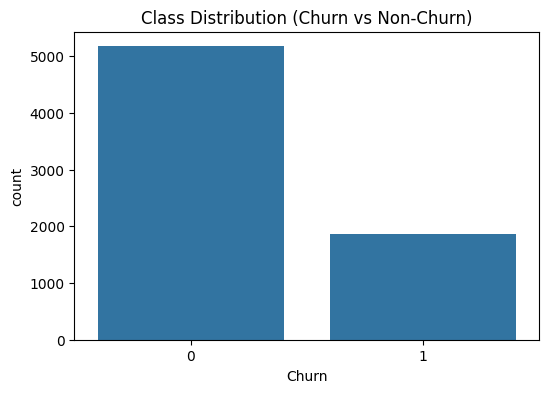

In [15]:
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Class Distribution (Churn vs Non-Churn)')
plt.show()

##Distribution of Key Numerical features

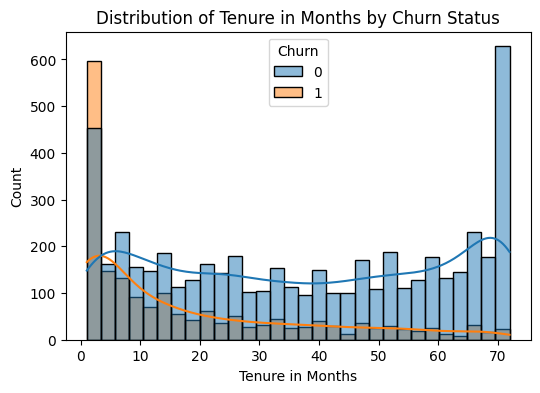

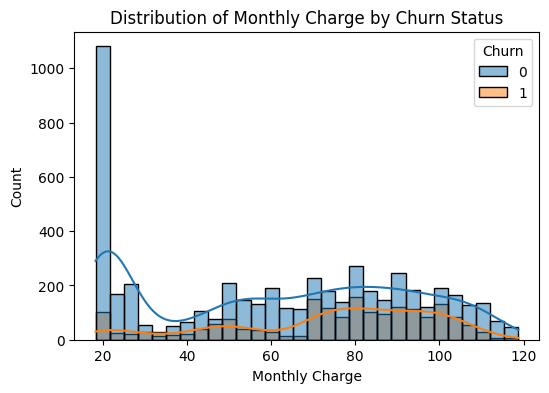

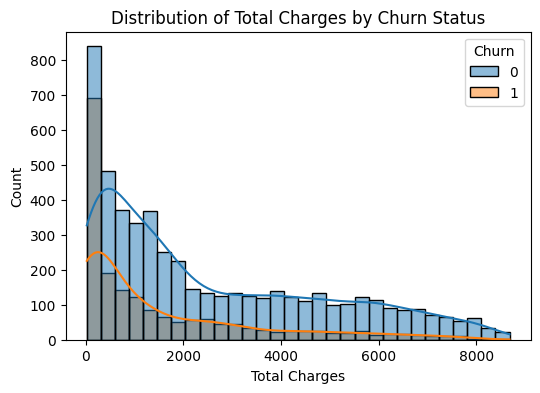

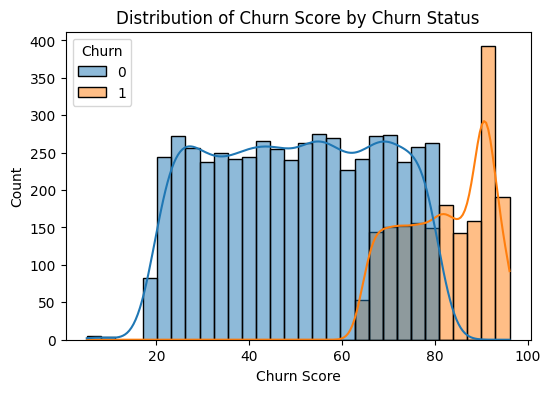

In [16]:
# Distribution of key numerical features
num_cols = ['Tenure in Months', 'Monthly Charge', 'Total Charges', 'Churn Score']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f'Distribution of {col} by Churn Status')
    plt.show()

##Correlation heatmaps

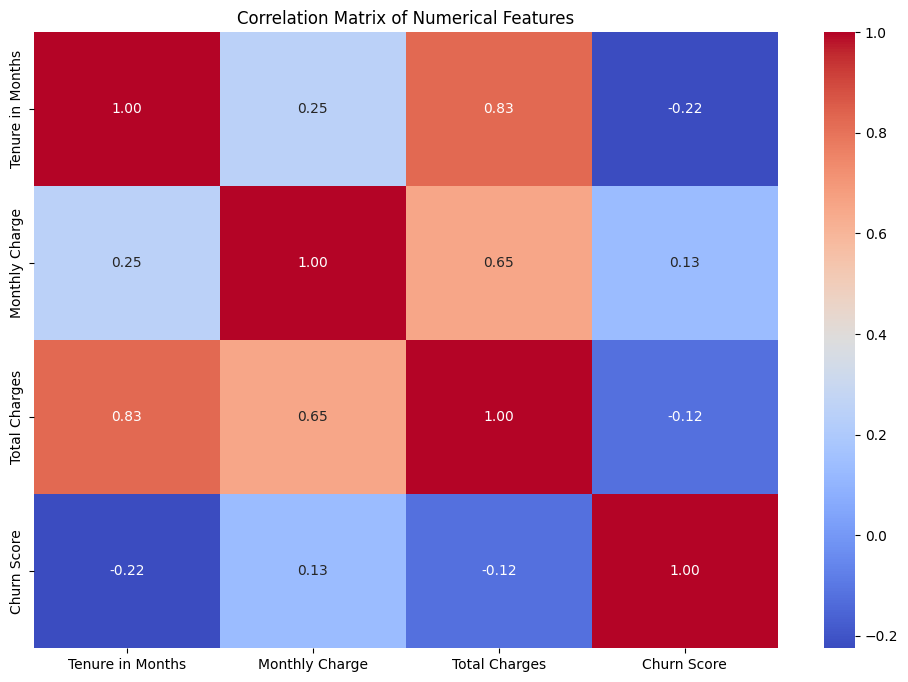

In [18]:
#Correlation heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

##Splitting the data into training and testing sets

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42)

##Handle Class Imbalance

In [21]:
from imblearn.over_sampling import SMOTE

# Check class distribution
print("Class distribution:")
print(y.value_counts(normalize=True))

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))

# Note: Use X_train_res and y_train_res for training instead of original data

Class distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

After SMOTE:
Churn
1    0.5
0    0.5
Name: proportion, dtype: float64


#Algorithm Comparison

##Logistic Regression

In [22]:
#Train with logistic regression
model = LogisticRegression()
model.fit(X_train,y_train)
y_prob = model.predict_proba(X_test)[:, 1]
#Predict on the test]
y_pred = model.predict(X_test)

###Hyperparameter tuning

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with compatible solver-penalty combinations
param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'max_iter': [100, 200, 500]
    },
    {
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'max_iter': [100, 200, 500]
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.5, 0.9],  # Required for elasticnet
        'max_iter': [100, 200, 500]
    },
    {
        'penalty': [None],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'max_iter': [100, 200, 500]
    }
]

# Create and fit the grid search
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and model
print("Best Logistic Regression Parameters:", grid_search.best_params_)
print("Best Logistic Regression AUC:", grid_search.best_score_)
best_log_reg = grid_search.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Logistic Regression Parameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression AUC: 1.0


###Feature importance analysis

<ipython-input-44-b79e0fa58700>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


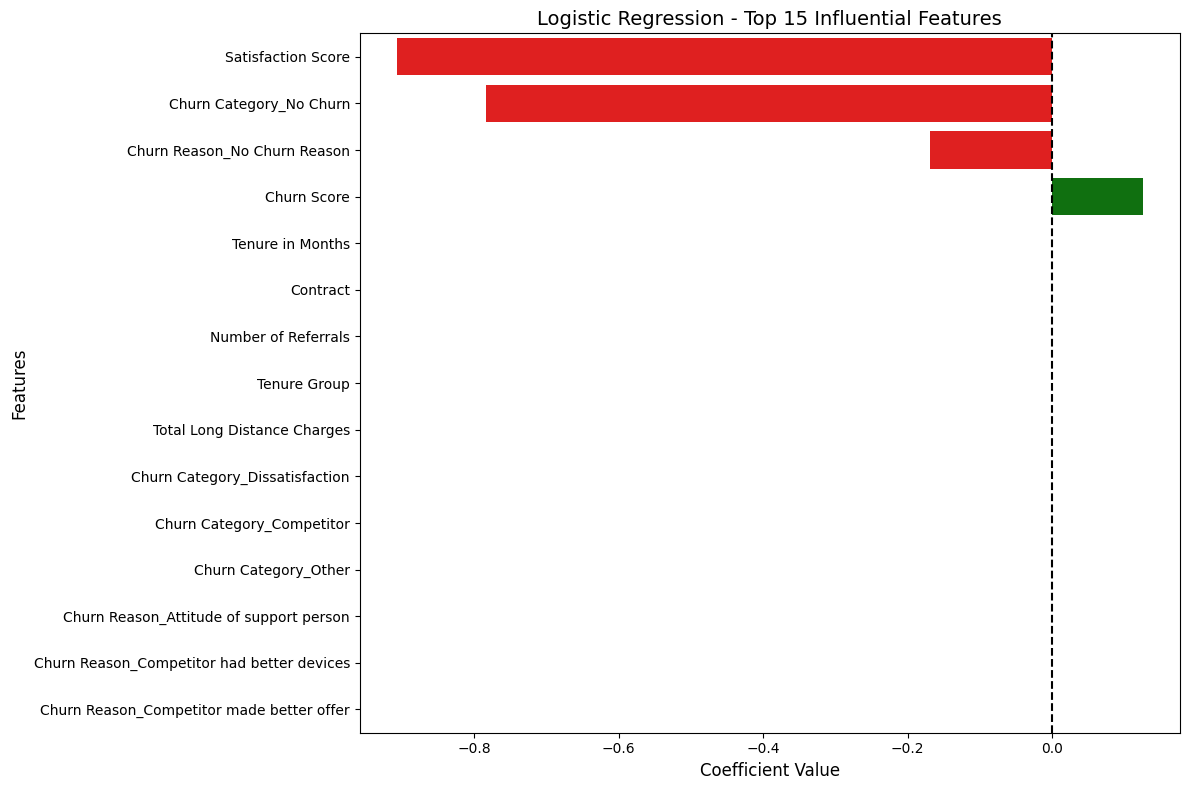


Logistic Regression Feature Coefficients:
                                       Feature  Coefficient  \
4                           Satisfaction Score    -0.906921   
9                      Churn Category_No Churn    -0.783665   
14                Churn Reason_No Churn Reason    -0.169408   
5                                  Churn Score     0.125391   
1                             Tenure in Months     0.000000   
2                                     Contract     0.000000   
0                          Number of Referrals     0.000000   
6                                 Tenure Group     0.000000   
3                  Total Long Distance Charges     0.000000   
8               Churn Category_Dissatisfaction     0.000000   
7                    Churn Category_Competitor     0.000000   
10                        Churn Category_Other     0.000000   
11     Churn Reason_Attitude of support person     0.000000   
12  Churn Reason_Competitor had better devices     0.000000   
13   Churn R

In [44]:
# First ensure you have the best estimator from your grid search
if hasattr(grid_search, 'best_estimator_'):
    best_log_reg = grid_search.best_estimator_

    # Check if the model has been fitted
    if hasattr(best_log_reg, 'coef_'):
        # Create feature importance dataframe
        lr_coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': best_log_reg.coef_[0],
            'Absolute_Coefficient': np.abs(best_log_reg.coef_[0])
        }).sort_values('Absolute_Coefficient', ascending=False)

        # Plot top 15 features
        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='Coefficient',
            y='Feature',
            data=lr_coefs.head(15),
            palette=['red' if x < 0 else 'green' for x in lr_coefs.head(15)['Coefficient']]
        )
        plt.title('Logistic Regression - Top 15 Influential Features', fontsize=14)
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()

        # Print feature coefficients
        print("\nLogistic Regression Feature Coefficients:")
        print(lr_coefs.head(15))
    else:
        print("Warning: The logistic regression model has not been fitted properly.")
else:
    print("Warning: No best estimator found from grid search.")

##Gradient Boosting

In [45]:
#Initialize, train and test with Gradient Boosting Classifier
learning_rates = [0.01, 0.05, 0.1, 0.2,0.5,1.0]
best_gb_auc = 0
best_gb_clf = None
best_lr = 0
for lr in learning_rates:
    gb_clf = GradientBoostingClassifier(n_estimators = 100,learning_rate=lr, max_depth=3, random_state=42)
    gb_clf.fit(X_train, y_train)
    y_pred_gb = gb_clf.predict(X_test)
    y_prob_gb = gb_clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob_gb)
    if auc > best_gb_auc:
        best_gb_auc = auc
        best_gb_clf = gb_clf
        best_lr = lr
print(lr)

1.0


###Feature importance analysis

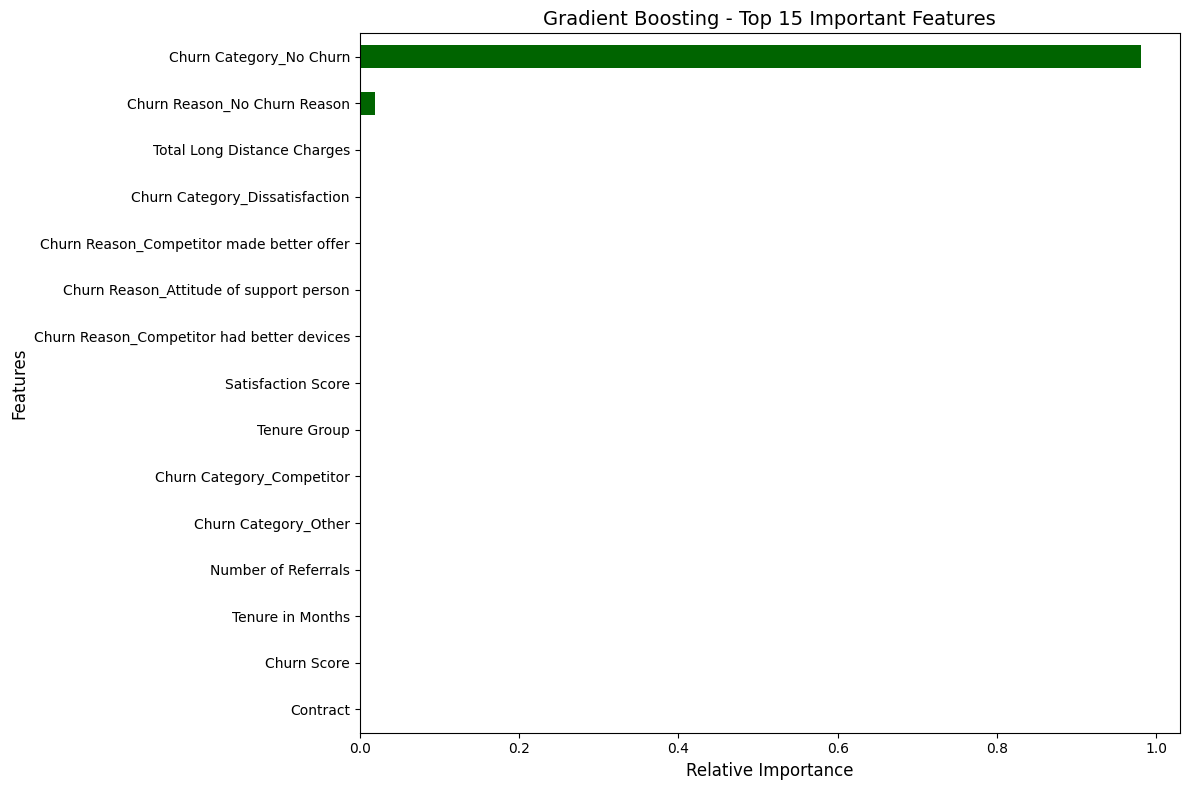


Gradient Boosting Feature Importance:
                                       Feature    Importance
9                      Churn Category_No Churn  9.804851e-01
14                Churn Reason_No Churn Reason  1.951492e-02
3                  Total Long Distance Charges  7.597312e-14
5                                  Churn Score  0.000000e+00
4                           Satisfaction Score  0.000000e+00
1                             Tenure in Months  0.000000e+00
0                          Number of Referrals  0.000000e+00
10                        Churn Category_Other  0.000000e+00
6                                 Tenure Group  0.000000e+00
8               Churn Category_Dissatisfaction  0.000000e+00
7                    Churn Category_Competitor  0.000000e+00
12  Churn Reason_Competitor had better devices  0.000000e+00
11     Churn Reason_Attitude of support person  0.000000e+00
13   Churn Reason_Competitor made better offer  0.000000e+00
2                                     Contract

In [28]:
# Gradient Boosting Feature Importance
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(gb_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgreen')
plt.title('Gradient Boosting - Top 15 Important Features', fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Create a detailed feature importance dataframe
gb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nGradient Boosting Feature Importance:")
print(gb_feature_importance.head(15))

###Hyperparameter tuning

In [29]:
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42),
                     gb_params,
                     cv=5,
                     scoring='roc_auc',
                     n_jobs=-1,
                     verbose=1)

gb_grid.fit(X_train_res, y_train_res)

print("Best Gradient Boosting Parameters:", gb_grid.best_params_)
print("Best Gradient Boosting AUC:", gb_grid.best_score_)

# Use best estimator
gb_model = gb_grid.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Gradient Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Best Gradient Boosting AUC: 1.0


##Neural Networks MLP Classifier

In [30]:
#Initialize, train and test Neural Network MLP Classifier
hidden_layers = (100,50,30,10)
mlp_model = MLPClassifier(hidden_layer_sizes=hidden_layers, max_iter=10000, random_state=42)
mlp_model.fit(X_train, y_train)
y_prob = mlp_model.predict_proba(X_test)[:, 1]
y_pred_mlp = mlp_model.predict(X_test)

###Feature importance analysis

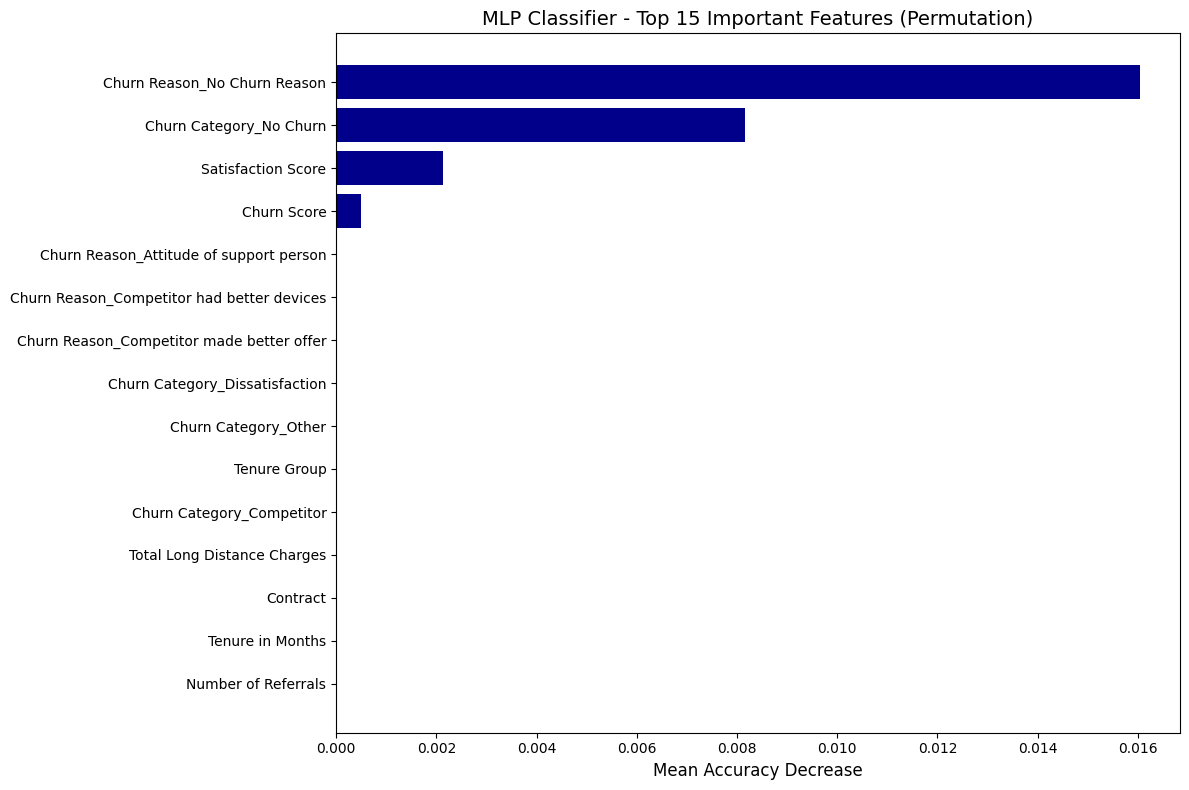


MLP Classifier Feature Importance (Permutation):
                                       Feature  Importance
14                Churn Reason_No Churn Reason    0.016040
9                      Churn Category_No Churn    0.008162
4                           Satisfaction Score    0.002129
5                                  Churn Score    0.000497
1                             Tenure in Months    0.000000
2                                     Contract    0.000000
0                          Number of Referrals    0.000000
6                                 Tenure Group    0.000000
3                  Total Long Distance Charges    0.000000
8               Churn Category_Dissatisfaction    0.000000
7                    Churn Category_Competitor    0.000000
10                        Churn Category_Other    0.000000
11     Churn Reason_Attitude of support person    0.000000
12  Churn Reason_Competitor had better devices    0.000000
13   Churn Reason_Competitor made better offer    0.000000


In [31]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance for MLP
mlp_perm_importance = permutation_importance(
    mlp_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Visualize top features
plt.figure(figsize=(12, 8))
sorted_idx = mlp_perm_importance.importances_mean.argsort()
top_features = 15  # Show top 15 features
plt.barh(
    X_train.columns[sorted_idx][-top_features:],
    mlp_perm_importance.importances_mean[sorted_idx][-top_features:],
    color='darkblue'
)
plt.title("MLP Classifier - Top 15 Important Features (Permutation)", fontsize=14)
plt.xlabel("Mean Accuracy Decrease", fontsize=12)
plt.tight_layout()
plt.show()

# Create detailed dataframe
mlp_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mlp_perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

print("\nMLP Classifier Feature Importance (Permutation):")
print(mlp_feature_importance.head(15))

###HyperParameter Tuning

In [32]:

# MLP hyperparameter grid
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'early_stopping': [True, False]
}

mlp_grid = GridSearchCV(MLPClassifier(random_state=42, max_iter=500),
                      mlp_params,
                      cv=3,  # Fewer folds due to longer training time
                      scoring='roc_auc',
                      n_jobs=-1,
                      verbose=1)

mlp_grid.fit(X_train_res, y_train_res)  # Using resampled data

print("Best MLP Parameters:", mlp_grid.best_params_)
print("Best MLP AUC:", mlp_grid.best_score_)

# Use best estimator
mlp_model = mlp_grid.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best MLP Parameters: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}
Best MLP AUC: 1.0


###Model Evaluation

In [46]:
#evaluate all models consistently
def evaluate_model(model, X_test, y_test, model_name=""):
    """
    Comprehensive evaluation of a classification model
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification report
    cr = classification_report(y_test, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn', 'Churn'],
                yticklabels=['Not Churn', 'Churn'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Print metrics
    print(f"\n{'='*50}")
    print(f"Evaluation Results for {model_name}")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(cr)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

##Model comparison


Evaluating Logistic Regression...


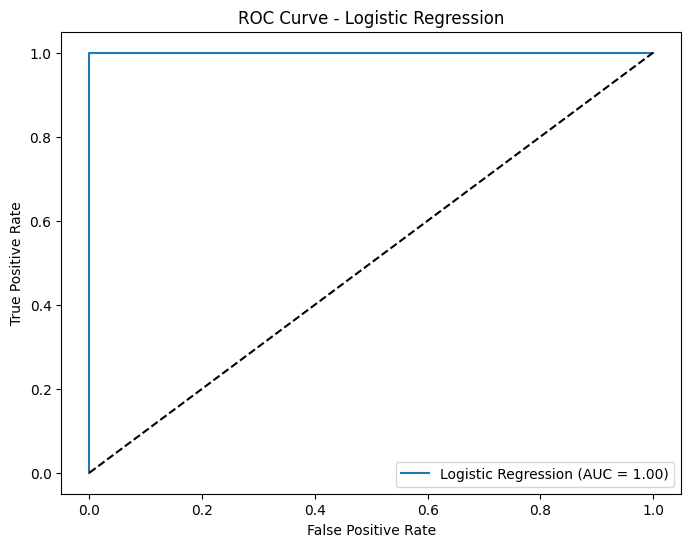

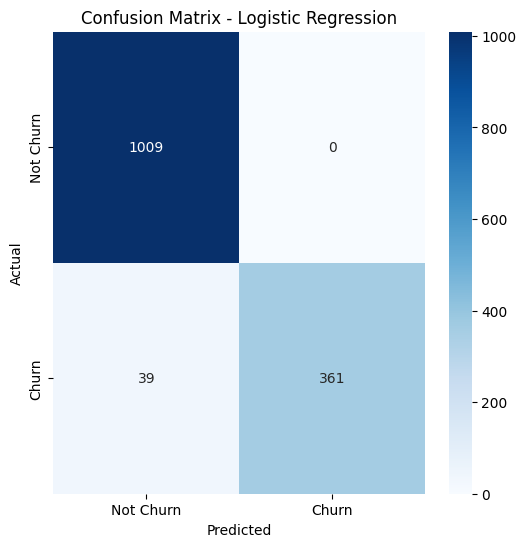


Evaluation Results for Logistic Regression
Accuracy: 0.9723
Precision: 1.0000
Recall: 0.9025
F1 Score: 0.9488
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1009
           1       1.00      0.90      0.95       400

    accuracy                           0.97      1409
   macro avg       0.98      0.95      0.96      1409
weighted avg       0.97      0.97      0.97      1409


Evaluating Gradient Boosting...


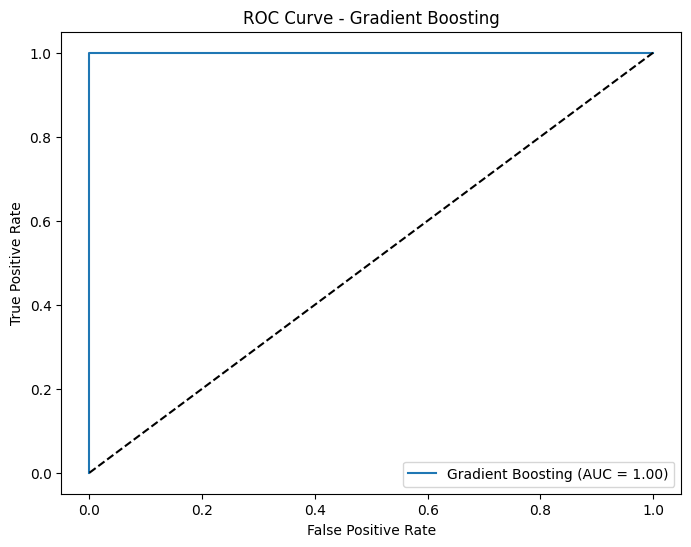

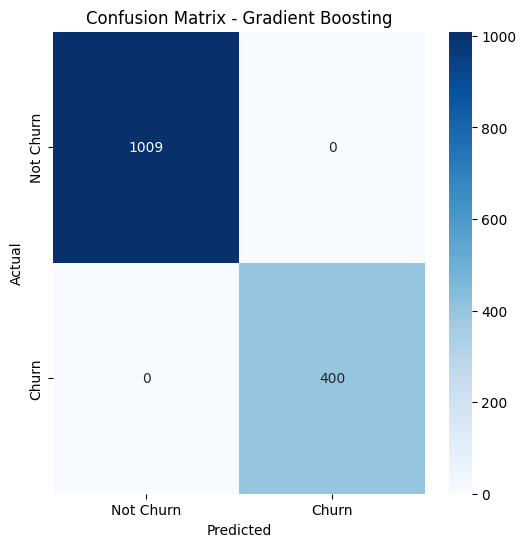


Evaluation Results for Gradient Boosting
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1009
           1       1.00      1.00      1.00       400

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


Evaluating Neural Network...


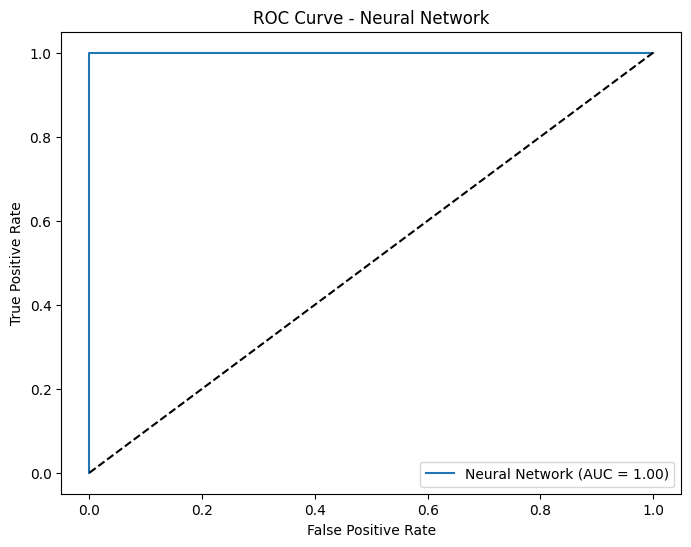

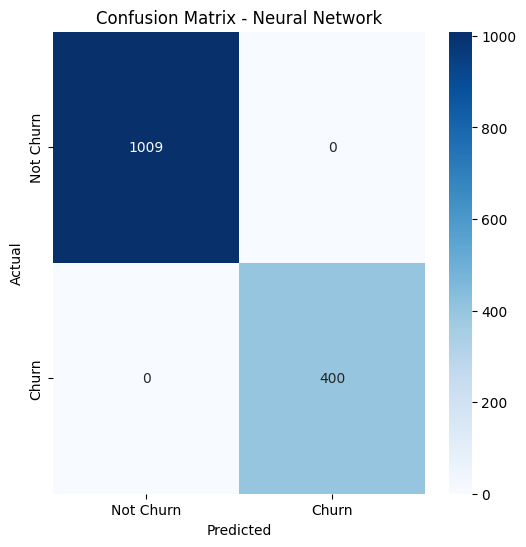


Evaluation Results for Neural Network
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1009
           1       1.00      1.00      1.00       400

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


Model Comparison:
                     accuracy  precision  recall        f1  roc_auc
Logistic Regression  0.972321        1.0  0.9025  0.948752      1.0
Gradient Boosting    1.000000        1.0  1.0000  1.000000      1.0
Neural Network       1.000000        1.0  1.0000  1.000000      1.0


<Figure size 1000x600 with 0 Axes>

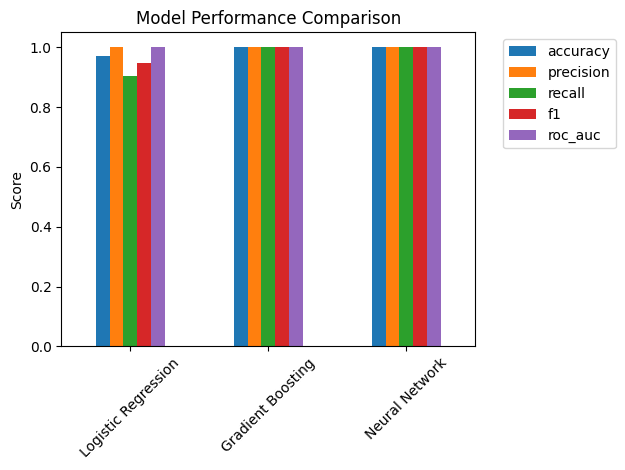

In [48]:
# Now evaluate each model
results = {}

# 1. Logistic Regression Evaluation
if 'grid_search' in globals() and hasattr(grid_search, 'best_estimator_'):
    log_reg = grid_search.best_estimator_
    print("\nEvaluating Logistic Regression...")
    results['Logistic Regression'] = evaluate_model(log_reg, X_test, y_test, "Logistic Regression")
else:
    print("Warning: Could not find fitted Logistic Regression model")
# 2. Gradient Boosting Evaluation
if 'gb_model' in globals():
    print("\nEvaluating Gradient Boosting...")
    results['Gradient Boosting'] = evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")

# 3. Neural Network Evaluation
if 'mlp_model' in globals():
    print("\nEvaluating Neural Network...")
    results['Neural Network'] = evaluate_model(mlp_model, X_test, y_test, "Neural Network")

# Compare all models
if results:
    print("\nModel Comparison:")
    comparison_df = pd.DataFrame(results).T
    print(comparison_df)

    # Plot comparison
    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar', y=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No trained models found for evaluation. Please check your model training code.")